**Predicting Youth Unemployment Barriers in Kenya Using AI**

This project uses a synthetic dataset of Kenyan youth to train a machine learning model that analyzes personal descriptions of job-seeking experiences. It predicts the main barrier to employment—such as a skills gap or lack of opportunities—and recommends targeted interventions. The goal is to support policymakers, job placement programs, and youth empowerment initiatives with AI-driven insights.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pickle
import random
import os

In [3]:
# Create directory for the model if it doesn't exist
if not os.path.exists('model'):
    os.makedirs('model')

**Creating a synthetic dataset for Kenyan youth employment with focus on unemployment barriers**

In [4]:
# Create a synthetic dataset for Kenyan youth employment with focus on unemployment barriers
def create_kenya_youth_employment_dataset(n=1000):
    # Set random seed for reproducibility
    random.seed(42)
    
    # Define demographics
    age_range = list(range(18, 36))
    education_levels = ['Primary', 'Secondary', 'Diploma', 'Bachelor', 'Masters', 'PhD']
    counties = ['Nairobi', 'Mombasa', 'Kisumu', 'Nakuru', 'Eldoret', 'Machakos', 'Nyeri', 'Kakamega']
    employment_status = ['Employed', 'Self-employed', 'Unemployed', 'Student', 'Unpaid work']
    
    # Define unemployment barrier categories
    unemployment_barriers = ['Skills_Gap', 'Opportunity_Shortage', 'Resource_Constraints', 
                             'Market_Mismatch', 'Geographic_Barrier']
    
    # Generate random data
    data = {
        'age': np.random.choice(age_range, n),
        'gender': np.random.choice(['Male', 'Female'], n),
        'education': np.random.choice(education_levels, n, p=[0.15, 0.35, 0.2, 0.2, 0.08, 0.02]),
        'county': np.random.choice(counties, n),
        'employment_status': np.random.choice(employment_status, n, p=[0.3, 0.15, 0.4, 0.1, 0.05]),
        'years_experience': np.random.choice(range(0, 15), n),
        'job_applications': np.random.choice(range(0, 50), n),
        'months_unemployed': np.random.choice(range(0, 36), n)
    }
    
    df = pd.DataFrame(data)
    
    # Generate unemployment barriers and descriptions based on demographics
    barriers = []
    descriptions = []
    
    # Description templates for each barrier type
    skills_gap_templates = [
        "I lack the technical skills needed for jobs in my field",
        "My education didn't provide practical skills employers need",
        "Companies want experience with technologies I haven't learned",
        "I need additional training to qualify for available positions",
        "My current skills are outdated for the modern job market in {county}"
    ]
    
    opportunity_shortage_templates = [
        "There are very few job openings in {county}",
        "The economy isn't creating enough jobs for graduates",
        "Too many graduates are competing for too few positions",
        "Companies aren't hiring in my field right now",
        "The job market in {county} is saturated with job seekers"
    ]
    
    resource_constraints_templates = [
        "I can't afford the transportation costs for interviews",
        "Starting my own business requires capital I don't have",
        "I lack resources to continue searching for jobs",
        "The cost of living while job hunting is too high",
        "I need financial support to relocate where jobs are available"
    ]
    
    market_mismatch_templates = [
        "My {education} qualification doesn't match what employers want",
        "The industry I trained for is declining in Kenya",
        "My field of study doesn't have many opportunities locally",
        "My skills are not valued in the current job market",
        "There's a disconnect between my education and available jobs"
    ]
    
    geographic_barrier_templates = [
        "Jobs in my field are only available far from where I live",
        "Living in {county} limits my access to job opportunities",
        "I can't relocate to where the jobs are available",
        "There's an urban-rural divide in job availability",
        "Remote work options are limited in my field"
    ]
    
    for i in range(n):
        status = df.loc[i, 'employment_status']
        education = df.loc[i, 'education']
        county = df.loc[i, 'county']
        experience = df.loc[i, 'years_experience']
        applications = df.loc[i, 'job_applications']
        
        # Determine barrier probability based on employment status and education
        if status == 'Unemployed':
            if education in ['Primary', 'Secondary']:
                # Less educated - more likely to face skills gap
                barrier_probs = [0.5, 0.2, 0.15, 0.05, 0.1]
            elif education in ['Diploma', 'Bachelor']:
                # Mid-level education - more likely to face opportunity shortage
                barrier_probs = [0.2, 0.4, 0.1, 0.2, 0.1]
            else:
                # Higher education - more likely to face market mismatch
                barrier_probs = [0.1, 0.2, 0.1, 0.5, 0.1]
        elif status == 'Student':
            # Students more concerned about future opportunities
            barrier_probs = [0.3, 0.3, 0.15, 0.15, 0.1]
        elif status == 'Unpaid work':
            # Unpaid workers often lack resources or face opportunity shortage
            barrier_probs = [0.2, 0.3, 0.3, 0.1, 0.1]
        else:
            # Employed or self-employed looking to improve situation
            barrier_probs = [0.2, 0.15, 0.25, 0.2, 0.2]
        
        # Adjust for geography - rural counties have higher geographic barriers
        if county in ['Nairobi', 'Mombasa', 'Kisumu']:
            # Adjust down geographic barrier for urban areas
            barrier_probs[4] *= 0.5
            # Normalize probabilities
            barrier_probs = [p/sum(barrier_probs) for p in barrier_probs]
        
        # Select barrier based on probabilities
        barrier = np.random.choice(unemployment_barriers, p=barrier_probs)
        barriers.append(barrier)
        
        # Generate description based on barrier
        if barrier == 'Skills_Gap':
            template = random.choice(skills_gap_templates)
        elif barrier == 'Opportunity_Shortage':
            template = random.choice(opportunity_shortage_templates)
        elif barrier == 'Resource_Constraints':
            template = random.choice(resource_constraints_templates)
        elif barrier == 'Market_Mismatch':
            template = random.choice(market_mismatch_templates)
        else:  # Geographic_Barrier
            template = random.choice(geographic_barrier_templates)
        
        description = template.format(education=education, county=county)
        descriptions.append(description)
    
    df['unemployment_barrier'] = barriers
    df['description'] = descriptions
    
    # Create intervention recommendations based on barriers
    interventions = []
    
    for barrier in barriers:
        if barrier == 'Skills_Gap':
            intervention = random.choice([
                'Technical training program', 
                'Digital skills bootcamp',
                'Industry certifications',
                'Apprenticeship placement'
            ])
        elif barrier == 'Opportunity_Shortage':
            intervention = random.choice([
                'Job creation initiative',
                'Public works program',
                'Entrepreneurship support',
                'Gig economy onboarding'
            ])
        elif barrier == 'Resource_Constraints':
            intervention = random.choice([
                'Startup capital support',
                'Job search stipend',
                'Transport subsidy',
                'Business incubation'
            ])
        elif barrier == 'Market_Mismatch':
            intervention = random.choice([
                'Career redirection counseling',
                'Industry transition program',
                'Skill conversion training',
                'Alternative career path mentorship'
            ])
        else:  # Geographic_Barrier
            intervention = random.choice([
                'Remote work opportunity',
                'Relocation support',
                'Commuter subsidy',
                'Satellite office placement'
            ])
        
        interventions.append(intervention)
    
    df['recommended_intervention'] = interventions
    
    return df

In [5]:
# Create and save the dataset
df = create_kenya_youth_employment_dataset(1000)
df.to_csv('kenya_youth_employment.csv', index=False)

In [6]:
df.head()

,age,gender,education,county,employment_status,years_experience,job_applications,months_unemployed,unemployment_barrier,description,recommended_intervention
0,24,Male,Diploma,Machakos,Unemployed,12,43,13,Skills_Gap,I lack the technical skills needed for jobs in...,Industry certifications
1,22,Female,Bachelor,Kakamega,Student,3,22,28,Skills_Gap,I lack the technical skills needed for jobs in...,Industry certifications
2,26,Male,Diploma,Nakuru,Employed,0,23,18,Market_Mismatch,My field of study doesn't have many opportunit...,Alternative career path mentorship
3,19,Female,Secondary,Machakos,Unemployed,14,17,33,Resource_Constraints,Starting my own business requires capital I do...,Job search stipend
4,26,Female,Bachelor,Nakuru,Employed,4,41,33,Resource_Constraints,Starting my own business requires capital I do...,Business incubation


In [7]:
df.shape

(1000, 11)

In [8]:
print("\nDataset Overview:")
print(f"Total records: {len(df)}")


Dataset Overview:
Total records: 1000


In [9]:
print("\nEmployment status distribution:")
print(df['employment_status'].value_counts())


Employment status distribution:
employment_status
Unemployed       416
Employed         277
Self-employed    160
Student           94
Unpaid work       53
Name: count, dtype: int64


In [10]:
print("\nUnemployment barrier distribution:")
print(df['unemployment_barrier'].value_counts())


Unemployment barrier distribution:
unemployment_barrier
Skills_Gap              287
Opportunity_Shortage    244
Resource_Constraints    194
Market_Mismatch         157
Geographic_Barrier      118
Name: count, dtype: int64


In [11]:
print("\nRecommended interventions sample:")
print(df['recommended_intervention'].value_counts().head())


Recommended interventions sample:
recommended_intervention
Industry certifications       82
Entrepreneurship support      75
Technical training program    73
Apprenticeship placement      70
Gig economy onboarding        66
Name: count, dtype: int64


**Visualizations**

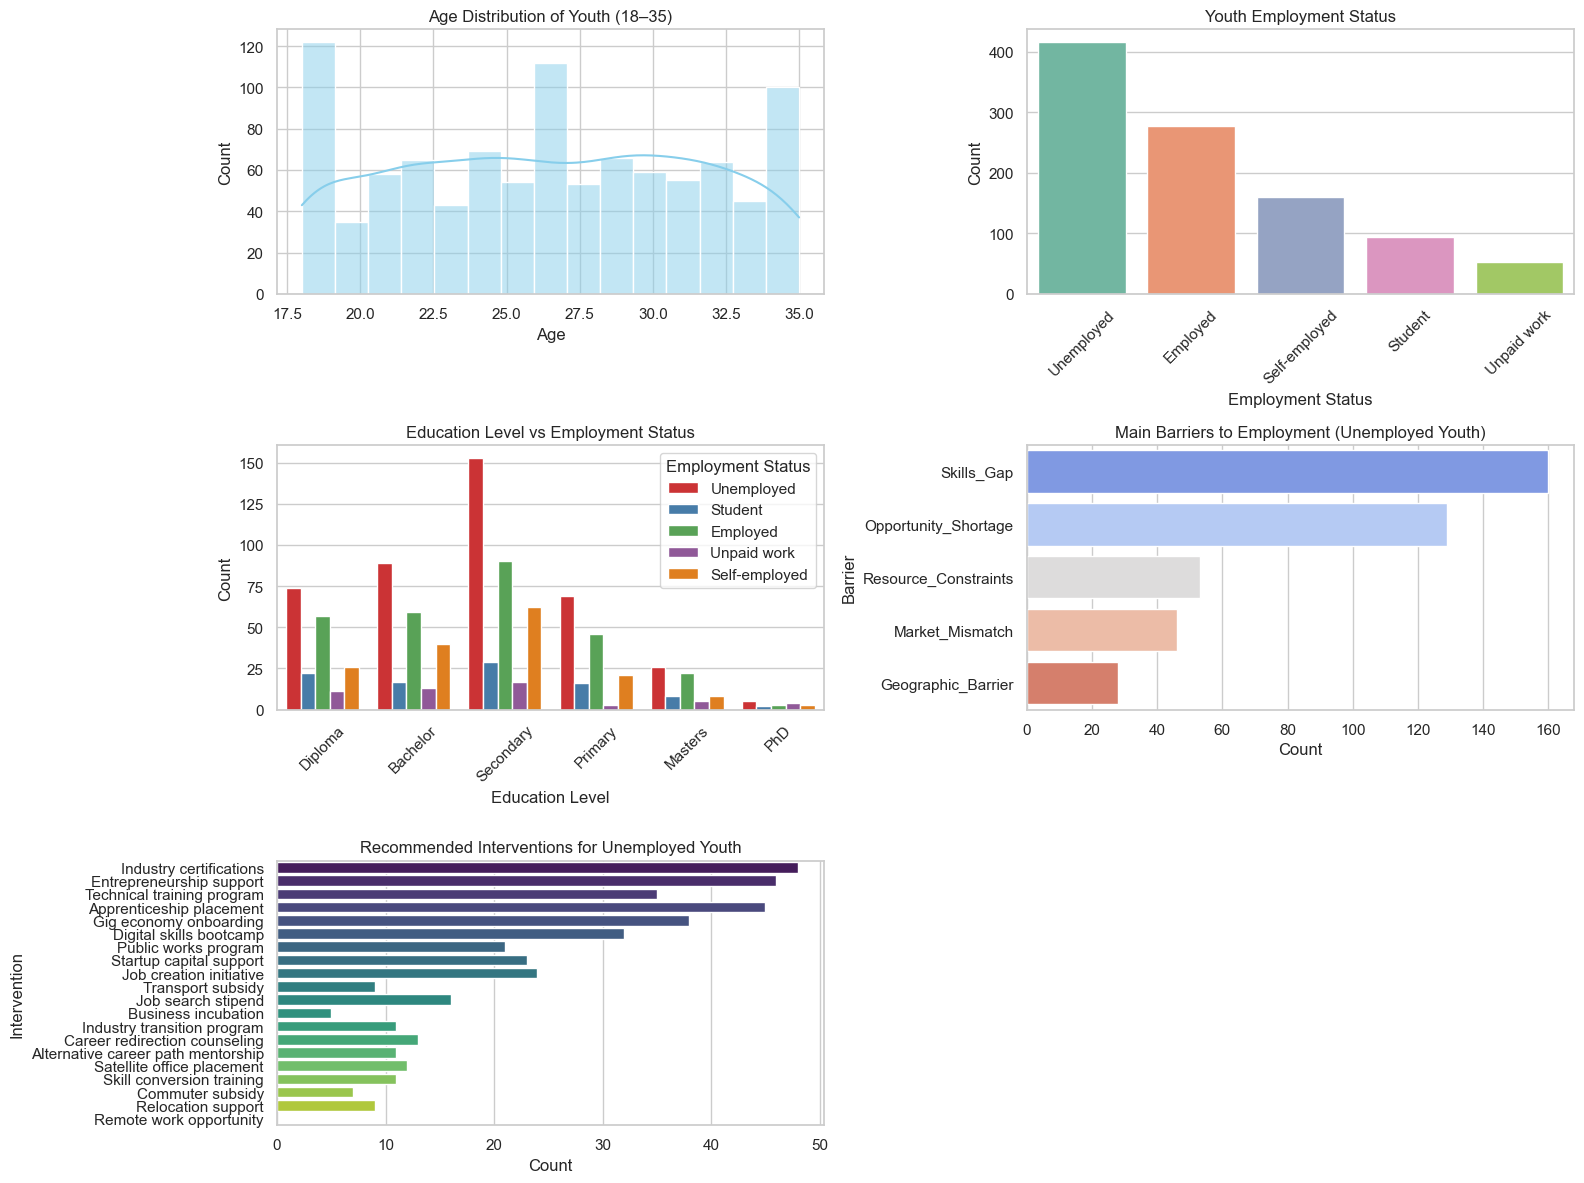

In [12]:
# Filter for youth aged 18–35
df_youth = df[(df['age'] >= 18) & (df['age'] <= 35)]

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

# 1. Age distribution
plt.subplot(3, 2, 1)
sns.histplot(df_youth['age'], bins=15, kde=True, color='skyblue')
plt.title('Age Distribution of Youth (18–35)')
plt.xlabel('Age')
plt.ylabel('Count')

# 2. Employment status distribution
plt.subplot(3, 2, 2)
sns.countplot(data=df_youth, x='employment_status',
              order=df_youth['employment_status'].value_counts().index,
              palette='Set2')
plt.title('Youth Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 3. Education level vs. Employment status
plt.subplot(3, 2, 3)
sns.countplot(data=df_youth, x='education', hue='employment_status', palette='Set1')
plt.title('Education Level vs Employment Status')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Employment Status')

# 4. Unemployment barriers
plt.subplot(3, 2, 4)
sns.countplot(data=df_youth[df_youth['employment_status'] == 'Unemployed'],
              y='unemployment_barrier',
              order=df_youth['unemployment_barrier'].value_counts().index,
              palette='coolwarm')
plt.title('Main Barriers to Employment (Unemployed Youth)')
plt.xlabel('Count')
plt.ylabel('Barrier')

# 5. Recommended interventions
plt.subplot(3, 2, 5)
sns.countplot(data=df_youth[df_youth['employment_status'] == 'Unemployed'],
              y='recommended_intervention',
              order=df_youth['recommended_intervention'].value_counts().index,
              palette='viridis')
plt.title('Recommended Interventions for Unemployed Youth')
plt.xlabel('Count')
plt.ylabel('Intervention')

# Adjust layout
plt.tight_layout()
plt.show()

**Preprocessing and training the model**

In [13]:
X = df['description']
y = df['unemployment_barrier']

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
 #Create and train the model pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [16]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                      precision    recall  f1-score   support

  Geographic_Barrier       1.00      1.00      1.00        16
     Market_Mismatch       1.00      1.00      1.00        36
Opportunity_Shortage       1.00      1.00      1.00        50
Resource_Constraints       1.00      1.00      1.00        43
          Skills_Gap       1.00      1.00      1.00        55

            accuracy                           1.00       200
           macro avg       1.00      1.00      1.00       200
        weighted avg       1.00      1.00      1.00       200



In [17]:
# Save the model
with open('model/unemployment_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("\nModel saved as 'model/unemployment_model.pkl'")


Model saved as 'model/unemployment_model.pkl'


In [18]:
# Create intervention mapping for the web app
intervention_mapping = {
    'Skills_Gap': [
        'Technical training program', 
        'Digital skills bootcamp',
        'Industry certifications',
        'Apprenticeship placement'
    ],
    'Opportunity_Shortage': [
        'Job creation initiative',
        'Public works program',
        'Entrepreneurship support',
        'Gig economy onboarding'
    ],
    'Resource_Constraints': [
        'Startup capital support',
        'Job search stipend',
        'Transport subsidy',
        'Business incubation'
    ],
    'Market_Mismatch': [
        'Career redirection counseling',
        'Industry transition program',
        'Skill conversion training',
        'Alternative career path mentorship'
    ],
    'Geographic_Barrier': [
        'Remote work opportunity',
        'Relocation support',
        'Commuter subsidy',
        'Satellite office placement'
    ]
}

In [19]:
# Save the intervention mapping
with open('model/intervention_mapping.pkl', 'wb') as f:
    pickle.dump(intervention_mapping, f)
print("\nIntervention mapping saved as 'model/intervention_mapping.pkl'")


Intervention mapping saved as 'model/intervention_mapping.pkl'
